# EM-algorithm for Gaussian Mixture Modeling

### Introduction

Gaussian mixture models (GMMs) are a type of machine learning algorithm. They are used to classify data into different categories based on the probability distribution. Gaussian mixture models can be used in many different areas, including finance, marketing and so much more. Clustering as a method of finding subgroups in observations is widely used in applications such as market segmentation where we are trying to find some structure in the data. Although the machine learning technique is not supervised, clusters can be used as features in a supervised machine learning model.

In this mini project, the Gaussian Mixture model will be considered in more detail. The following issues will be more carefully considered and implemented:
1. Generate Gaussian Mixture Model sample data using the make_blobs function, create a visualization
2. Fit a Gaussian Mixture Model and create a plot
3. Create version of the make_blobs function that create 2D Gaussian distributions and create a binary classification dataset in which one class consists of 3 blobs and the other class consists of 3 blobs. Plot the resulting dataset
4. Implement GMM-based classification using the fit/predict functions of the GMM model
5. Implement the EM-algorithm for Gaussian Mixture Models (GMMs) from "scratch"

To get started, we need to unload the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib as mpl

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import itertools

from scipy import linalg


##### 1. Generate Gaussian Mixture Model sample data using the make_blobs function. Create and plot a dataset with 3 blobs and 1000 samples. 

To generate Gaussian Mixture Model we use the standard function in scikit-learn called make_blobs. As indicated in the task, we form 1000 samples and three blobs. And immediately check the resulting volume and visualize

In [2]:
# Generate some data
X, y = make_blobs(n_samples=1000,  n_features=3, cluster_std = 0.90, random_state = 0)

In [3]:
print(X.shape)
print(y.shape)

(1000, 3)
(1000,)


KMeans is a clustering algorithm that divides observations into k clusters. Since we can dictate the number of clusters, it can be easily used in classification where we divide the data into clusters that can be equal to or greater than the number of classes. Here data devided to 3 clasters

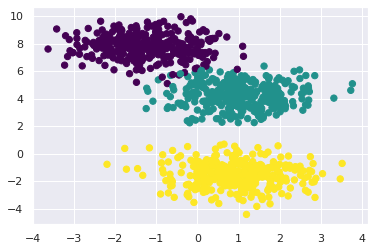

In [4]:
# Plot the data with K Means Labels
kmeans = KMeans(3, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

As a result, we see that the result is achieved, Gaussian Mixture Model is generated and visualized

#### 2. Fit a Gaussian Mixture Model using sklearn on generated data and create plot.

As it well known, to build a prediction model, we need to build boundaries between clusters, for this we will carry out the next iteration.

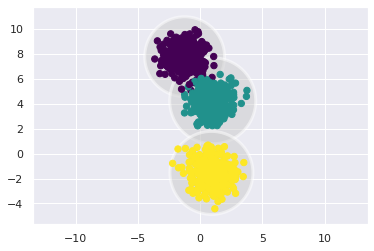

In [5]:
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=3, random_state=0)
plot_kmeans(kmeans, X)

As a result, it is clear that on our dataset the border is clearly visible and the clusters practically do not intersect

#### 3. Create your own version of the make_blobs function that create 2D Gaussian distributions with arbitrary covariance matrices (not just isotropic) and create a binary classification dataset in which one class consists of 3 blobs and the other consists class consists of 3 blobs. Plot the resulting dataset

The data generation version without using the make_blobs function with the specified parameters is below. Also used data visualization

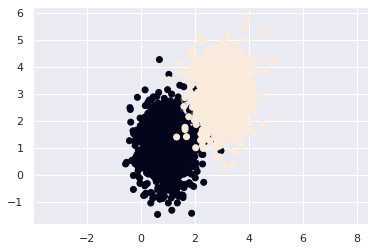

In [6]:
means = [[1,1],[3,3]]
covs = [[0.3,0],[0,0.7]]
n = 1000
np.random.seed(1223)

X1 = np.vstack([np.random.multivariate_normal(i, covs, n) for i in means])
y1 = np.repeat([0,1],n)
plt.scatter(X1[:,0], X1[:,1],c = y1)
plt.axis('equal')
plt.show()

#### 4. Implement GMM-based classification using the fit/predict functions of the GMM model in sklearn. 

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

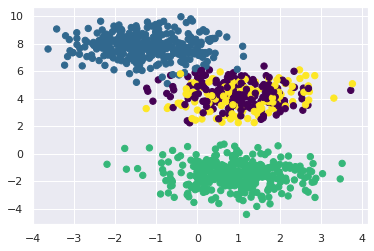

In [7]:
# from sklearn.mixture import GMM
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

#### 5. Implement the EM-algorithm for Gaussian Mixture Models (GMMs) from "scratch". Use the make_blobs and your own version to check that it works and provided plots showing the results.

First let load a small new data points for implement GMM on 2d data points with convex shapes

In [10]:
from keras.datasets import mnist

def load_data(  num_samples, prior_z_list , mu_list , sigma_list ):
	X=[]
	choice_of_gaussian_model = np.random.choice(len( prior_z_list), num_samples, p=prior_z_list  )
	for sample_ind in range(num_samples):
		gaussian_ind = choice_of_gaussian_model[sample_ind]
		x= np.random.multivariate_normal( mu_list[gaussian_ind], sigma_list[gaussian_ind] )
		X.append(x)

	X= np.asarray(X)
	return X

real_phi =  [0.2,0.6,0.1,0.1]
real_mu = [ [0,0],[2,8],[10,10],[9,1] ]
real_sigma = [ [[1,0.5],[0.5,1]], [[2,-0.6],[-0.6,1]], [[1,0],[0,1]],[[1,0.3],[0.3,0.5]] ]
X=load_data(10000, real_phi, real_mu, real_sigma )

2022-04-15 15:30:58.396101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 15:30:58.396130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
for i in range(len(real_phi)):
    print("real phi: ", real_phi[i], " real mu: ", real_mu[i], " real sigma: ", real_sigma[i])


real phi:  0.2  real mu:  [0, 0]  real sigma:  [[1, 0.5], [0.5, 1]]
real phi:  0.6  real mu:  [2, 8]  real sigma:  [[2, -0.6], [-0.6, 1]]
real phi:  0.1  real mu:  [10, 10]  real sigma:  [[1, 0], [0, 1]]
real phi:  0.1  real mu:  [9, 1]  real sigma:  [[1, 0.3], [0.3, 0.5]]


Let’s plot the data and have a look at it.

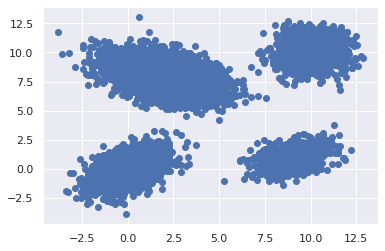

In [12]:
plt.scatter( X[:,0], X[:,1] )
plt.show()

Then we apply the EM algorithm, to get the MLE of GMM parameters and get the cluster function

In [13]:
def EM(X, num_clusters, epsilon = 1e-2, update_prior = True, max_iter = 100000 ):
	x_dim = X.shape[1]
	num_samples = X.shape[0]
	## initialization
	mu = np.random.uniform( size=( num_clusters, x_dim ) )
	## initializing sigma as identity matrix can guarantee it's positive definite
	sigma = []
	for _ in range(num_clusters):
		sigma.append( np.eye(x_dim) )
	sigma = np.asarray(sigma)
	phi = np.ones(num_clusters)/ num_clusters

	count = 0

	while True:
		## E step
		# Q is the posterior, with the dimension num_samples x num_clusters
		Q=np.zeros( [num_samples, num_clusters])
		sigma_det =[ (np.linalg.det(sigma[j]))**0.5 for j in range(num_clusters)  ]
		sigma_inverse = [ np.linalg.inv(sigma[j]) for j in range(num_clusters)  ]
		for i in range(num_samples):
			for j in range(num_clusters):
				Q[i,j]= phi[j]/(   sigma_det[j] ) * np.exp( -0.5 * np.matmul( np.matmul((X[i]-mu[j]).T, sigma_inverse[j]), X[i]-mu[j]))   
		Q=np.array(Q)
		Q=Q/(np.sum(Q,axis=1,keepdims=True))	

		## M step
		# update mu
		mu_new = np.ones([num_clusters, x_dim])
		for j in range(num_clusters):
			mu_new[j] = np.sum (Q[:,j:j+1]*X ,axis=0 )/np.sum(Q[:,j],axis=0)
		# update sigma
		sigma_new = np.zeros_like(sigma)
		for j in range(num_clusters):
			for i in range(num_samples):
				sigma_new[j] += Q[i,j] * np.matmul( (X[i]-mu[j])[:,np.newaxis], (X[i]-mu[j])[:,np.newaxis].T )
			sigma_new[j] = sigma_new[j]/np.sum(Q[:,j])
		# update phi
		if update_prior:
			phi_new = np.mean( Q, axis=0 )
		else:
			phi_new = phi

		delta_change = np.mean(np.abs(phi-phi_new)) + np.mean( np.abs( mu- mu_new ) )+np.mean( np.abs( sigma- sigma_new ) )
		print("parameter changes: ",delta_change)
		
		if delta_change < epsilon:
			break
		
		count +=1
		if count >= max_iter:
			break

		phi=phi_new
		mu= mu_new
		sigma = sigma_new
        
    ## a function used for performing clustering
	def cluster( X ):
		Q=np.zeros( [X.shape[0], num_clusters])
		sigma_det =[ (np.linalg.det(sigma[j]))**0.5 for j in range(num_clusters)  ]
		sigma_inverse = [ np.linalg.inv(sigma[j]) for j in range(num_clusters)  ]
		for i in range(X.shape[0]):
			for j in range(num_clusters):
				Q[i,j]= phi[j]/(  sigma_det[j] ) * np.exp( -0.5 * np.matmul( np.matmul((X[i]-mu[j]).T, sigma_inverse[j]), X[i]-mu[j]))   
		Q=np.array(Q)
		Q=Q/(np.sum(Q,axis=1,keepdims=True))	
		cluster_info = np.argmax( Q, axis=1)
		return cluster_info


	return {"mu":mu, "sigma":sigma, "phi":phi, "cluster": cluster}

params=EM(X, num_clusters=4, epsilon= 1E-4)
mu= params["mu"]
sigma = params["sigma"]
phi=params["phi"]
cluster = params["cluster"]

parameter changes:  18.689338753957
parameter changes:  11.833137902851025
parameter changes:  1.782758110397537
parameter changes:  1.7139568366929405
parameter changes:  1.1794623052737467
parameter changes:  0.4177976275689458
parameter changes:  0.15196449386116695
parameter changes:  0.030242626506892325
parameter changes:  0.01560558325746676
parameter changes:  0.01291324857871302
parameter changes:  0.011099229255272468
parameter changes:  0.009638208033981863
parameter changes:  0.00845262369214008
parameter changes:  0.00747428431760821
parameter changes:  0.006655355780879433
parameter changes:  0.00596154005946304
parameter changes:  0.005367581701941168
parameter changes:  0.004854470005597033
parameter changes:  0.004407631966600001
parameter changes:  0.004015723238778083
parameter changes:  0.003669794861105729
parameter changes:  0.0033627045606147536
parameter changes:  0.003088692090974482
parameter changes:  0.002843067436110413
parameter changes:  0.002628524444070

In [14]:
esti_mu= (mu*100).astype(np.int32)/100.  
esti_sigma= (sigma*100).astype(np.int32)/100. 
esti_phi= (phi*100).astype(np.int32)/100. 
for i in range(len(esti_phi)):
    print("esti phi:", esti_phi[i], "esti mu:", esti_mu[i].tolist(), "esti sigma:", esti_sigma[i].tolist())


esti phi: 0.4 esti mu: [2.23, 7.91] esti sigma: [[1.74, -0.52], [-0.52, 0.91]]
esti phi: 0.19 esti mu: [9.47, 5.37] esti sigma: [[1.23, 2.48], [2.48, 21.13]]
esti phi: 0.18 esti mu: [1.51, 8.14] esti sigma: [[2.03, -0.62], [-0.62, 1.12]]
esti phi: 0.2 esti mu: [0.0, -0.02] esti sigma: [[1.01, 0.5], [0.5, 0.99]]


If we compare the estimated parameters with the real paramets, we can see the estimation error is within 0.05, and the correspondence between the phi, mu and sigma is also correct. Therefore the EM algorithm does work

We can perform clustering using the trained cluster model and plot the clustering results

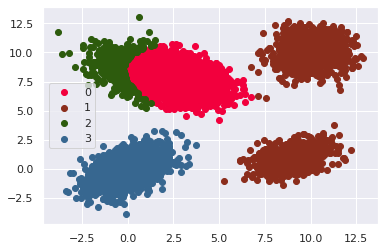

In [15]:
cluster_X = cluster(X)
cluster_index = np.unique(cluster_X)
for ind in cluster_index:
	plt.scatter( X[cluster_X==ind][:,0], X[cluster_X==ind][:,1], color = np.random.uniform(size=3) )
plt.legend(cluster_index)
plt.show()

In the result, the clustering results are pretty accurate and reasonable